<a href="https://colab.research.google.com/github/aitormorais/DIPC/blob/main/Cnn_but.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar librerias

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Para este cuaderno haremos uso de un [dataset](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification)obtenido de kaggle

Lo tengo almacenado en drive, por lo que tendremos que montar el drive

Paso 1: Importar la biblioteca de drive

In [2]:
from google.colab import drive

Paso 2: Montar la carpeta

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Paso 3: Cargar datos de entrenamiento

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Cnn_data/Training_set.csv')

In [4]:
test = pd.read_csv('/content/drive/MyDrive/Cnn_data/Testing_set.csv')

In [5]:
nombres = sorted(train['label'].unique())

Paso 4: Creamos un dicionario donde almacenaremos el nombre del tipo de mariposa(clave) y el numero existente en el dataset(valor)

In [6]:

# Crear un diccionario donde las claves son las clases  y los valores son 0
diccionario = {nombre: 0 for nombre in sorted(train['label'].unique())}


Paso 5: Contamos por cada clase cuantas imagenes tenemos

In [7]:
for nombre in train['label']:
  diccionario[nombre] += 1


¿Esta la suma bien hecha?

In [11]:
sum(diccionario.values()) == len(train['label'])

True

Graficamos el dataset

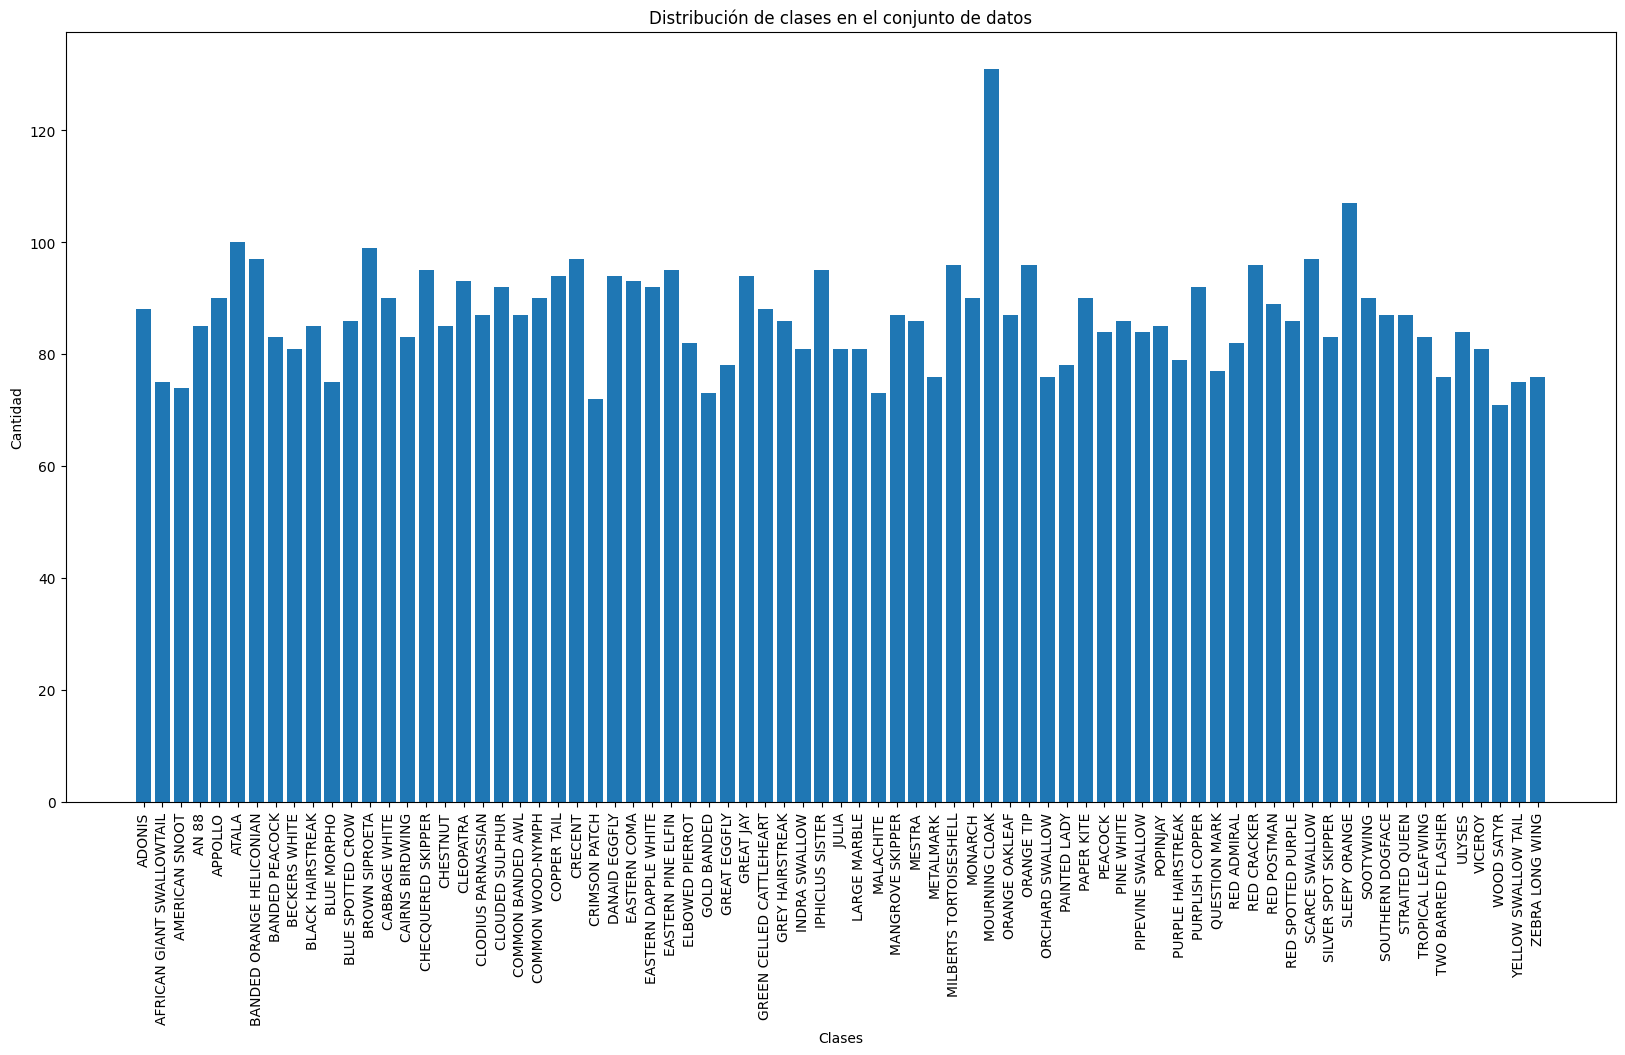

In [12]:
plt.figure(figsize=(20, 10))
plt.bar(diccionario.keys(), diccionario.values())
plt.title('Distribución de clases en el conjunto de datos')
plt.xlabel('Clases')
plt.ylabel('Cantidad')
plt.xticks(rotation=90) # Esto rota los nombres de las clases en el eje x para mejorar la visibilidad
plt.show()


In [8]:
def calcular_porcentajes(diccionario):
    """Calcula el porcentaje de cada clase en el diccionario proporcionado."""
    # Calcular la suma total de los valores en el diccionario
    suma_total = sum(diccionario.values())
    # Crear un nuevo diccionario para almacenar los porcentajes
    porcentajes = {}
    # Calcular el porcentaje de cada clase
    for clase in diccionario:
        porcentajes[clase] = (diccionario[clase] / suma_total) * 100
    return porcentajes

In [9]:
def imprimir_porcentajes(porcentajes):
    """Imprime los porcentajes en un formato legible."""
    # Imprimir los porcentajes
    for clase in porcentajes:
        print(f'{clase}: {porcentajes[clase]:.2f}%')

Imprimos el porcentaje, es decir que porcentaje representa cada clase del dataset

In [15]:
# Calcular los porcentajes
porcentajes = calcular_porcentajes(diccionario)

# Imprimir los porcentajes
imprimir_porcentajes(porcentajes)


ADONIS: 1.35%
AFRICAN GIANT SWALLOWTAIL: 1.15%
AMERICAN SNOOT: 1.14%
AN 88: 1.31%
APPOLLO: 1.38%
ATALA: 1.54%
BANDED ORANGE HELICONIAN: 1.49%
BANDED PEACOCK: 1.28%
BECKERS WHITE: 1.25%
BLACK HAIRSTREAK: 1.31%
BLUE MORPHO: 1.15%
BLUE SPOTTED CROW: 1.32%
BROWN SIPROETA: 1.52%
CABBAGE WHITE: 1.38%
CAIRNS BIRDWING: 1.28%
CHECQUERED SKIPPER: 1.46%
CHESTNUT: 1.31%
CLEOPATRA: 1.43%
CLODIUS PARNASSIAN: 1.34%
CLOUDED SULPHUR: 1.42%
COMMON BANDED AWL: 1.34%
COMMON WOOD-NYMPH: 1.38%
COPPER TAIL: 1.45%
CRECENT: 1.49%
CRIMSON PATCH: 1.11%
DANAID EGGFLY: 1.45%
EASTERN COMA: 1.43%
EASTERN DAPPLE WHITE: 1.42%
EASTERN PINE ELFIN: 1.46%
ELBOWED PIERROT: 1.26%
GOLD BANDED: 1.12%
GREAT EGGFLY: 1.20%
GREAT JAY: 1.45%
GREEN CELLED CATTLEHEART: 1.35%
GREY HAIRSTREAK: 1.32%
INDRA SWALLOW: 1.25%
IPHICLUS SISTER: 1.46%
JULIA: 1.25%
LARGE MARBLE: 1.25%
MALACHITE: 1.12%
MANGROVE SKIPPER: 1.34%
MESTRA: 1.32%
METALMARK: 1.17%
MILBERTS TORTOISESHELL: 1.48%
MONARCH: 1.38%
MOURNING CLOAK: 2.02%
ORANGE OAKLEAF: 1.34%
O

Empezamos con la CNN

In [10]:
def img_prepoces(ruta, tupla):
    """
    Función para leer, convertir y redimensionar una imagen utilizando OpenCV.

    Parámetros:
    - ruta (str): Una cadena que representa la ruta del archivo de imagen a procesar.
    - tupla (tuple): Un tuple que contiene dos elementos que representan la altura y el ancho (respectivamente) a los que se debe redimensionar la imagen.

    Devoluciones:
    - ndarray: Una matriz Numpy que representa la imagen procesada y normalizada.

    Esta función realiza los siguientes pasos:
    1. Lee la imagen de la ruta especificada usando `cv2.imread()`.
    2. Convierte la imagen de BGR a RGB usando `cv2.cvtColor()`.
    3. Redimensiona la imagen al tamaño especificado por la tupla usando `cv2.resize()`.
    4. Normaliza la imagen dividiéndola por 255. Esto se hace para cambiar los valores de los píxeles de la imagen de 0-255 a 0-1, un rango más adecuado para el entrenamiento de modelos de red neuronal.
    """
    return cv2.resize(cv2.cvtColor(cv2.imread(ruta), cv2.COLOR_BGR2RGB), (tupla[0], tupla[1])) / 255


In [11]:
def construir_modelo_fc(forma_entrada, func_acti, num_capas, filtro_inicial, n_clases, n_neuronas_fc):
    """
    Función para construir una red neuronal convolucional (CNN) con Keras.

    Parámetros:
    - forma_entrada (tuple): Un tuple que define la forma de los datos de entrada (altura, ancho, canales).
    - func_acti (str): Una cadena que define la función de activación a utilizar en las capas convolucionales y densas. Ejemplos: 'relu', 'sigmoid', 'tanh'.
    - num_capas (int): Un entero que define el número de capas convolucionales a añadir a la red.
    - filtro_inicial (int): Un entero que define el número de filtros en la primera capa convolucional. Las capas convolucionales subsiguientes duplicarán el número de filtros.
    - n_clases (int): Un entero que define el número de clases objetivo para la clasificación.
    - n_neuronas_fc (int): Un entero que define el número de neuronas en la capa totalmente conectada (capa densa).

    Devoluciones:
    - model (keras.Model): El modelo de la red neuronal convolucional.
    """
    model = Sequential()
    model.add(Conv2D(filtro_inicial, (3, 3), activation=func_acti, input_shape=forma_entrada))
    model.add(MaxPooling2D((2, 2)))
    for i in range(1, num_capas):
        model.add(Conv2D(filtro_inicial*(2**i), (3, 3), activation=func_acti))
        model.add(MaxPooling2D((2, 2)))
    #Añadir capas densas
    model.add(Flatten())#importante esta capa ya que convierte 2d a 1d para capas densas
    model.add(Dense(n_neuronas_fc, activation=func_acti))
    model.add(Dropout(0.5))
    model.add(Dense(n_clases, activation='softmax'))

    return model

In [12]:
def convertir_labels_one_hot(ytrain, yval):
    """
    Esta función convierte las etiquetas categóricas de texto a formato one-hot.

    Argumentos:
        ytrain: Serie de pandas o array de NumPy que contiene las etiquetas de las muestras de entrenamiento.
        yval: Serie de pandas o array de NumPy que contiene las etiquetas de las muestras de validación.

    Retorna:
        Dos arrays de NumPy que representan las etiquetas de las muestras de entrenamiento y validación,
        respectivamente, en formato one-hot.
    """

    # Crear el codificador
    le = LabelEncoder()

    # Ajustar el codificador a las etiquetas de entrenamiento y transformar las etiquetas a números enteros
    y_train_int = le.fit_transform(ytrain)

    # Utilizar el codificador ajustado para transformar las etiquetas de validación a números enteros
    y_val_int = le.transform(yval)

    # Convertir los números enteros a formato one-hot y devolverlos
    return to_categorical(y_train_int), to_categorical(y_val_int)

In [13]:
def dimensiones(ruta):
    """
    Función para obtener las dimensiones de una imagen utilizando OpenCV.

    Parámetros:
    - ruta (str): Una cadena que representa la ruta del archivo de imagen a procesar.

    Devoluciones:
    - tuple: Un tuple que contiene las dimensiones de la imagen. El formato de la tupla devuelta es (altura, ancho, canales), donde 'canales' generalmente es 3 para imágenes en color (RGB).

    Esta función realiza los siguientes pasos:
    1. Lee la imagen de la ruta especificada usando `cv2.imread()`.
    2. Convierte la imagen de BGR a RGB usando `cv2.cvtColor()`.
    3. Devuelve la forma de la matriz de la imagen usando el atributo `.shape` de numpy, que representa las dimensiones de la imagen.
    """
    return cv2.cvtColor(cv2.imread(ruta), cv2.COLOR_BGR2RGB).shape


In [20]:
dimensiones('/content/drive/MyDrive/Cnn_data/train/Image_1.jpg')[:2]

(224, 224)

1-Dividir el dataset en train y validation

In [14]:
#crear el array donde guardaremos las imagenes en forma de matrix
train_img = []

2-Convertir las imagenes a una matrix

In [22]:
!pip install gdown


https://drive.google.com/file/d/10_Kqvd5Eg9Ej8N46TIm6JFb1T70RZnuM/view?usp=drive_link

https://drive.google.com/file/d/10_Kqvd5Eg9Ej8N46TIm6JFb1T70RZnuM/view?usp=sharing

In [ ]:
https://drive.google.com/file/d/10_Kqvd5Eg9Ej8N46TIm6JFb1T70RZnuM/view?usp=sharing

In [47]:
!gdown --id '10_Kqvd5Eg9Ej8N46TIm6JFb1T70RZnuM/view?usp' -O archive.zip


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=10_Kqvd5Eg9Ej8N46TIm6JFb1T70RZnuM/view?usp 



In [23]:
! pip install -q kaggle

In [15]:
from google.colab import files

In [25]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"moraisa","key":"4484f2817b1b2e903814d3c30721a59a"}'}

In [53]:
 ! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [16]:
! cp kaggle.json ~/.kaggle/

In [27]:
!chmod 600 ~/.kaggle/kaggle.json


In [28]:
!kaggle datasets download -d phucthaiv02/butterfly-image-classification

 99% 224M/226M [00:10<00:00, 23.1MB/s]
100% 226M/226M [00:10<00:00, 22.0MB/s]


In [65]:
!ls

drive  kaggle.json  sample_data  test  Testing_set.csv	train  Training_set.csv


In [33]:
!unzip -q butterfly-image-classification.zip
!rm butterfly-image-classification.zip


unzip:  cannot find or open butterfly-image-classification.zip, butterfly-image-classification.zip.zip or butterfly-image-classification.zip.ZIP.
rm: cannot remove 'butterfly-image-classification.zip': No such file or directory


NameError: ignored

In [67]:
!cd /content/train

In [17]:
for name in train['filename']:
    nombre = "/content/train/"+name
    train_img.append(img_prepoces(nombre,dimensiones(nombre)[:2]))

tqdm

gdown

In [18]:
for name in train['filename']:
    nombre = "/content/drive/MyDrive/Cnn_data/train/"+name
    train_img.append(img_prepoces(nombre,dimensiones(nombre)[:2]))

KeyboardInterrupt: ignored

3-Guardar las etiquetas

In [18]:
names = train['label']

4-Dividir los datos

In [19]:
X_train_img, X_val_img, y_train_names, y_val_names = train_test_split(train_img, names, test_size=0.2, random_state=42)

Resize:
 se espera que las imagenes de entrada esten en un array 4d, con forma (numero de imagenes,altura,ancho,canales)

In [ ]:
X_train_img = np.array(X_train_img).reshape(-1, 224, 224, 3)
X_val_img = np.array(X_val_img).reshape(-1, 224, 224, 3)

Definimos los parametros para hacer uso del data augmentation

In [ ]:
# Crear un generador de datos de imagen con aumentación
datagen = ImageDataGenerator(
        rotation_range=30,  # Rotar aleatoriamente las imágenes
        zoom_range = 0.1, # Zoom aleatoriamente las imágenes dentro del rango
        width_shift_range=0.1,  # Desplazar aleatoriamente las imágenes horizontalmente
        height_shift_range=0.1,  # Desplazar aleatoriamente las imágenes verticalmente
        horizontal_flip=True,  # Invertir aleatoriamente las imágenes horizontalmente
        vertical_flip=False)  # No invertir las imágenes verticalmente

Ajustamos el generador de datos a los datos de entrenamiento

In [ ]:
datagen.fit(X_train_img)

Convertimos las etiquetas a formato one-hot

In [ ]:
y_train_names,y_val_names = convertir_labels_one_hot(y_train_names, y_val_names)

Callbacks

In [ ]:
callbacks = [
    ModelCheckpoint("mejor.h5", save_best_only=True),  # Guarda el mejor modelo como 'mejor_modelo.h5'
    EarlyStopping(patience=10, restore_best_weights=True),  # Detén el entrenamiento si el modelo deja de mejorar
    ReduceLROnPlateau(patience=5)  # Reduce la tasa de aprendizaje si el modelo deja de mejorar
]


Creamos el modelo

In [ ]:
modelo = construir_modelo_fc((224,224,3),'relu',4,16,75,512)

Compilamos el modelo

In [ ]:
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Entrenamos el modelo

In [ ]:
history = modelo.fit(datagen.flow(X_train_img, y_train_names, batch_size=32),
                    validation_data=(X_val_img, y_val_names),
                    steps_per_epoch=len(X_train_img) // 32,
                    epochs=65)